In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

In [ ]:
BATCH_SIZE=64

# Data Preparation

In [ ]:
train_ds,val_ds,test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete7HRH5Y/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete7HRH5Y/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete7HRH5Y/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for review,label in val_ds.take(2):
  print(review)
  print(label)

tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
tf.Tensor(1, shape=(),

In [ ]:
def standardization(input_data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    lowercase=tf.strings.lower(input_data)
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

    return output

In [ ]:
standardization(tf.constant("<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this movie! would you?<br> <br /><br />T"))

<tf.Tensor: shape=(), dtype=string, numpy=b'in the movie man called t\xc3\xa9v\xc3\xa8z went to a friend\xe2\x80\x99s plce and they had a tensed discussion i don\xe2\x80\x99t love this movie would you t'>

In [ ]:
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

In [ ]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [ ]:
# lengths=[]
# words=[]

# for review,label in train_ds.take(100):
#   # for word in tf.strings.split(review, sep=" "):
#   #   if word in words:
#   #     pass
#   #   else:
#   #     words.append(word)
#   lengths.append(len(tf.strings.split(review, sep=" ")))

In [ ]:
training_data=train_ds.map(lambda x,y:x)### input x and y and outputx
vectorize_layer.adapt(training_data)#### adapt the vectorize_layer to the training data

In [ ]:
len(vectorize_layer.get_vocabulary())

10000

In [ ]:
def vectorizer(review,label):
    return vectorize_layer(review),label

In [ ]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [ ]:
vectorize_layer.get_vocabulary()[411]

'absolutely'

In [ ]:
for review,label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [ ]:
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Modeling

## SimpleRNN

In [ ]:
inputs=np.random.random([32, 10, 8]).astype(np.float32)
simple_rnn=tf.keras.layers.SimpleRNN(25)
output=simple_rnn(inputs)
print(output.shape)

(32, 25)


In [ ]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    SimpleRNN(32),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 64)           640000    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 643,137
Trainable params: 643,137
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/rnn.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 [==============================] - 142s 360ms/step - loss: 0.6943 - accuracy: 0.4995 - val_loss: 0.6934 - val_accuracy: 0.5019
Epoch 2/10
391/391 [==============================] - 135s 345ms/step - loss: 0.6853 - accuracy: 0.5384 - val_loss: 0.6944 - val_accuracy: 0.4986
Epoch 3/10
391/391 [==============================] - 138s 352ms/step - loss: 0.6657 - accuracy: 0.5974 - val_loss: 0.6974 - val_accuracy: 0.5089
Epoch 4/10
391/391 [==============================] - 136s 349ms/step - loss: 0.6240 - accuracy: 0.6802 - val_loss: 0.7077 - val_accuracy: 0.5091
Epoch 5/10
391/391 [==============================] - 134s 344ms/step - loss: 0.5579 - accuracy: 0.7604 - val_loss: 0.7295 - val_accuracy: 0.5062
Epoch 6/10
391/391 [==============================] - 140s 359ms/step - loss: 0.5020 - accuracy: 0.8064 - val_loss: 0.7475 - val_accuracy: 0.5050
Epoch 7/10
391/391 [==============================] - 134s 342ms/step - loss: 0.4745 - accuracy: 0.8150 - val_loss: 0.7565 -

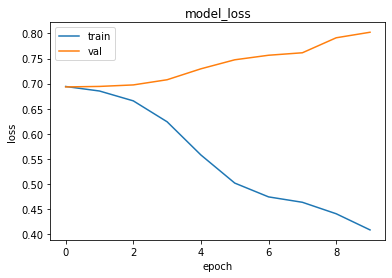

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

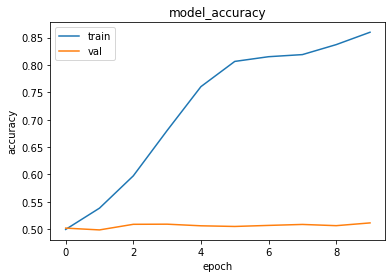

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [ ]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(train_dataset)

391/391 [==============================] - 16s 41ms/step - loss: 0.5160 - accuracy: 0.7563


[0.5160424709320068, 0.7563199996948242]

## LSTM (MultiLayer and Bidirectional)

In [ ]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(LSTM(64,return_sequences=True)),
    Bidirectional(LSTM(32)),
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 64)           1920000   
                                                                 
 bidirectional (Bidirectiona  (None, 250, 128)         66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/lstm.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 [==============================] - 41s 81ms/step - loss: 0.6326 - accuracy: 0.6146 - val_loss: 0.4056 - val_accuracy: 0.8210
Epoch 2/10
391/391 [==============================] - 28s 72ms/step - loss: 0.3347 - accuracy: 0.8670 - val_loss: 0.3285 - val_accuracy: 0.8602
Epoch 3/10
391/391 [==============================] - 29s 74ms/step - loss: 0.2476 - accuracy: 0.9098 - val_loss: 0.3591 - val_accuracy: 0.8638
Epoch 4/10
391/391 [==============================] - 30s 75ms/step - loss: 0.2030 - accuracy: 0.9306 - val_loss: 0.4211 - val_accuracy: 0.8514
Epoch 5/10
391/391 [==============================] - 29s 74ms/step - loss: 0.1797 - accuracy: 0.9407 - val_loss: 0.3940 - val_accuracy: 0.8550
Epoch 6/10
391/391 [==============================] - 28s 72ms/step - loss: 0.1581 - accuracy: 0.9479 - val_loss: 0.4271 - val_accuracy: 0.8374
Epoch 7/10
391/391 [==============================] - 27s 70ms/step - loss: 0.1289 - accuracy: 0.9606 - val_loss: 0.4573 - val_accuracy:

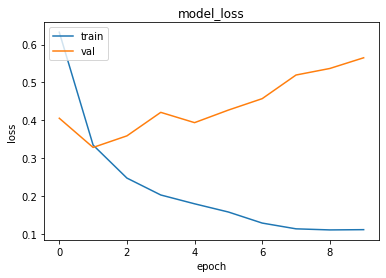

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

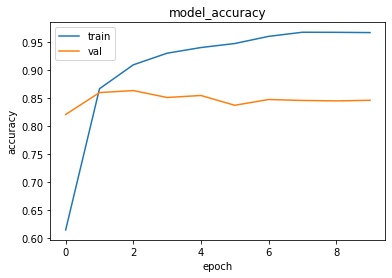

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [ ]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 [==============================] - 6s 29ms/step - loss: 0.5510 - accuracy: 0.8472


[0.5510271191596985, 0.8471999764442444]

## GRU (MultiLayer and Bidirectional)

In [ ]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(GRU(64,return_sequences=True)),
    Bidirectional(GRU(32)),
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 64)           640000    
                                                                 
 bidirectional (Bidirectiona  (None, 250, 128)         49920     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/gru.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[])

Epoch 1/10
391/391 [==============================] - 34s 59ms/step - loss: 0.6897 - accuracy: 0.5418 - val_loss: 0.6698 - val_accuracy: 0.5962
Epoch 2/10
391/391 [==============================] - 21s 54ms/step - loss: 0.4123 - accuracy: 0.8182 - val_loss: 0.3438 - val_accuracy: 0.8558
Epoch 3/10
391/391 [==============================] - 22s 56ms/step - loss: 0.2685 - accuracy: 0.8980 - val_loss: 0.3434 - val_accuracy: 0.8653
Epoch 4/10
391/391 [==============================] - 21s 55ms/step - loss: 0.2202 - accuracy: 0.9218 - val_loss: 0.3776 - val_accuracy: 0.8609
Epoch 5/10
391/391 [==============================] - 21s 54ms/step - loss: 0.1932 - accuracy: 0.9345 - val_loss: 0.4128 - val_accuracy: 0.8536
Epoch 6/10
391/391 [==============================] - 22s 55ms/step - loss: 0.1719 - accuracy: 0.9414 - val_loss: 0.3983 - val_accuracy: 0.8530
Epoch 7/10
391/391 [==============================] - 21s 54ms/step - loss: 0.1492 - accuracy: 0.9495 - val_loss: 0.4396 - val_accuracy:

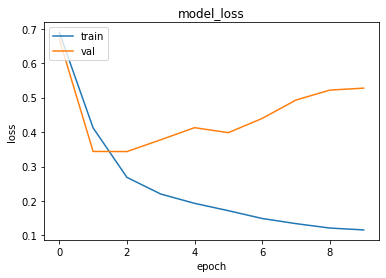

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

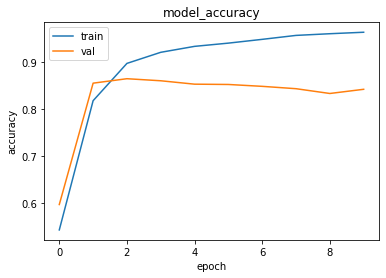

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [ ]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 [==============================] - 5s 27ms/step - loss: 0.5178 - accuracy: 0.8454


[0.517833411693573, 0.8453599810600281]

## Conv1D

In [ ]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 300)          3000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 248, 32)           28832     
                                                                 
 flatten_2 (Flatten)         (None, 7936)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                253984    
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,282,849
Trainable params: 3,282,849
No

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/conv_1d.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 [==============================] - 13s 32ms/step - loss: 0.6915 - accuracy: 0.5203 - val_loss: 0.6819 - val_accuracy: 0.6024
Epoch 2/10
391/391 [==============================] - 13s 32ms/step - loss: 0.4926 - accuracy: 0.7732 - val_loss: 0.3361 - val_accuracy: 0.8620
Epoch 3/10
391/391 [==============================] - 13s 32ms/step - loss: 0.2804 - accuracy: 0.8911 - val_loss: 0.3058 - val_accuracy: 0.8719
Epoch 4/10
391/391 [==============================] - 12s 31ms/step - loss: 0.2179 - accuracy: 0.9232 - val_loss: 0.3145 - val_accuracy: 0.8694
Epoch 5/10
391/391 [==============================] - 12s 31ms/step - loss: 0.1758 - accuracy: 0.9416 - val_loss: 0.3406 - val_accuracy: 0.8653
Epoch 6/10
391/391 [==============================] - 12s 31ms/step - loss: 0.1475 - accuracy: 0.9544 - val_loss: 0.3683 - val_accuracy: 0.8599
Epoch 7/10
391/391 [==============================] - 12s 31ms/step - loss: 0.1218 - accuracy: 0.9648 - val_loss: 0.4016 - val_accuracy:

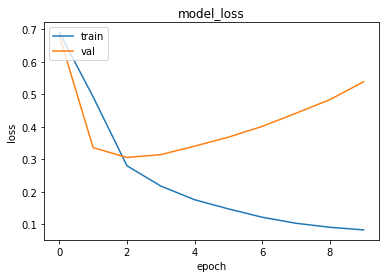

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

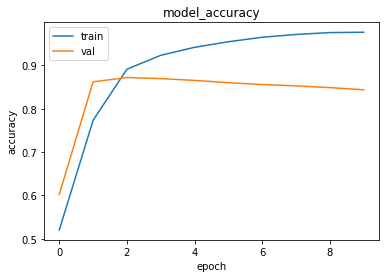

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 [==============================] - 4s 19ms/step - loss: 0.3094 - accuracy: 0.8690


[0.3093862235546112, 0.8689600229263306]

## Pretrained Word2Vec[Gensim]

In [ ]:
word2vec=api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
word2vec.vectors.shape

(3000000, 300)

In [ ]:
#print(word2vec.vocab)
len(word2vec['The'])

300

In [ ]:
word2vec.most_similar('Man')

[('Woman', 0.693934440612793),
 ('Boy', 0.5896924734115601),
 ('Girl', 0.584598958492279),
 ('Suspect', 0.5577560067176819),
 ('Couple', 0.5528684854507446),
 ('man', 0.5316052436828613),
 ('Robber', 0.5315312147140503),
 ('Teenager', 0.5161929130554199),
 ('depicts_Michelangelo_Creation', 0.5148171782493591),
 ('Policeman', 0.5136396288871765)]

In [ ]:
pretrained_embeddings=[]

In [ ]:
def first_caps(word):
  return word[0].upper()+word[1:]

In [ ]:
vectorize_layer.get_vocabulary()[2]

'the'

In [ ]:
#first_caps(vectorize_layer.get_vocabulary()[2])

'The'

In [ ]:
pretrained_embeddings=[]

In [ ]:
len(vectorize_layer.get_vocabulary())

10000

In [ ]:
for i in range(len(vectorize_layer.get_vocabulary())):
  try:
    pretrained_embeddings.append(word2vec[vectorize_layer.get_vocabulary()[i]])
  except:
    print(vectorize_layer.get_vocabulary()[i])
    try:
      pretrained_embeddings.append(word2vec[first_caps(vectorize_layer.get_vocabulary()[i])])
      print('toupper')
    except:
      print('nosolution')
      pretrained_embeddings.append(random.normal(loc=0, scale=1, size=(EMBEDDING_DIM)))#reloaded_word_vectors[vectorize_layer.get_vocabulary()[i]])
  if i%1000==0:
    print('iis====================================',i)


nosolution
iis==================================== 0
[UNK]
nosolution
and
toupper
a
toupper
of
toupper
to
toupper
doesnt
nosolution
didnt
nosolution
isnt
nosolution
wasnt
nosolution
10
nosolution
80s
nosolution
20
nosolution
70s
nosolution
iis==================================== 1000
15
nosolution
12
nosolution
30
nosolution
humour
toupper
100
nosolution
hasnt
nosolution
90
nosolution
shouldnt
nosolution
favourite
toupper
theatre
toupper
60s
nosolution
40
nosolution
lowbudget
nosolution
tarzan
toupper
50
nosolution
90s
nosolution
1950s
nosolution
iis==================================== 2000
keaton
toupper
welles
toupper
50s
nosolution
1010
nosolution
11
nosolution
1970s
nosolution
overthetop
nosolution
sinatra
toupper
columbo
toupper
1980s
nosolution
25
nosolution
1930s
nosolution
14
nosolution
13
nosolution
bmovie
nosolution
aint
toupper
pacino
toupper
moviethe
nosolution
writerdirector
nosolution
itthe
nosolution
lugosi
toupper
hitchcock
toupper
810
nosolution
iis===================

In [ ]:
pretrained_embeddings_array=np.array(pretrained_embeddings)
print(pretrained_embeddings_array.shape)

(10000, 300)


In [ ]:
#np.save('/content/drive/MyDrive/nlp/sentiment_analysis/pretrained_embeddings',pretrained_embeddings_array)

In [ ]:
pretrained_embeddings_array=np.load('/content/drive/MyDrive/nlp/sentiment_analysis/pretrained_embeddings.npy')

In [ ]:
pretrained_embeddings_array.shape

(10000, 300)

In [ ]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        embeddings_initializer=tf.keras.initializers.Constant(pretrained_embeddings_array),
        trainable=True,
    ),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 300)          3000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 248, 32)           28832     
                                                                 
 flatten_1 (Flatten)         (None, 7936)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                253984    
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,282,849
Trainable params: 3,282,849
No

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/conv_1d_word2vec.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/50
25/25 [==============================] - 10s 372ms/step - loss: 0.7380 - accuracy: 0.5144 - val_loss: 0.6953 - val_accuracy: 0.5048
Epoch 2/50
25/25 [==============================] - 6s 251ms/step - loss: 0.6849 - accuracy: 0.5337 - val_loss: 0.6952 - val_accuracy: 0.5051
Epoch 3/50
25/25 [==============================] - 6s 259ms/step - loss: 0.6765 - accuracy: 0.5619 - val_loss: 0.6971 - val_accuracy: 0.5081
Epoch 4/50
25/25 [==============================] - 6s 251ms/step - loss: 0.6665 - accuracy: 0.5894 - val_loss: 0.6961 - val_accuracy: 0.5101
Epoch 5/50
25/25 [==============================] - 4s 167ms/step - loss: 0.6508 - accuracy: 0.6156 - val_loss: 0.6974 - val_accuracy: 0.5054
Epoch 6/50
25/25 [==============================] - 6s 250ms/step - loss: 0.6379 - accuracy: 0.6244 - val_loss: 0.6993 - val_accuracy: 0.5128
Epoch 7/50
25/25 [==============================] - 4s 176ms/step - loss: 0.6204 - accuracy: 0.6488 - val_loss: 0.7035 - val_accuracy: 0.5092
Epoch

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-bc8ba518b435>", line 5, in <module>
    callbacks=[model_checkpoint_callback])
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1431, in fit
    _use_cached_eval_dataset=True)
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1716, in evaluate
    tmp_logs = self.test_function(iterator)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/u

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

# Testing

In [ ]:
# test_pos="this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "
# test_neg="very good start, but movie started becoming boring at some point and unfortunately i didn't feel like this was properly produced as there was too much background noise, and the actors didn't look motivated at all "

In [ ]:
test_data=tf.data.Dataset.from_tensor_slices([["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "],
                                              ["very good start, but movie started becoming interesting at some point and fortunately at some point it started becoming much more fun, though there was too much background noise, so in all i liked this movie "],])


In [ ]:
def vectorizer_test(review):
    return vectorize_layer(review)
test_dataset=test_data.map(vectorizer_test)

In [ ]:
model.predict(test_dataset)

array([[0.68417126],
       [0.55765617]], dtype=float32)

## Inference Ready Testing

In [ ]:
inputs = Input(shape=(1,), dtype="string")
vectorized_inputs=vectorize_layer(inputs) 
outputs = model(vectorized_inputs) 
inference_ready_model = tf.keras.Model(inputs, outputs) 
inference_ready_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 sequential_2 (Sequential)   (None, 1)                 3282849   
                                                                 
Total params: 3,282,849
Trainable params: 3,282,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
inference_ready_model.predict(["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! ",
                               "very good start, but movie started becoming interesting at some point and fortunately at some point it started becoming much more fun, though there was too much background noise, so in all i liked this movie "])

array([[0.68417126],
       [0.55765617]], dtype=float32)

# Visualize Embeddings

In [ ]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 300)          3000000   
                                                                 
 conv1d_3 (Conv1D)           (None, 248, 32)           28832     
                                                                 
 flatten_3 (Flatten)         (None, 7936)              0         
                                                                 
 dense_6 (Dense)             (None, 32)                253984    
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,282,849
Trainable params: 3,282,849
No

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
log_dir='logs/imdb/fit/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'/'

In [ ]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir,histogram_freq=1)

In [ ]:
history=model.fit(
    train_dataset.take(34),
    validation_data=val_dataset,
    epochs=1,
    callbacks=[tensorboard_callback])

34/34 [==============================] - 8s 209ms/step - loss: 0.6943 - accuracy: 0.4784 - val_loss: 0.6932 - val_accuracy: 0.4987


In [ ]:
with open(os.path.join(log_dir,'metadata.tsv'),"w",encoding="utf-8") as f:
  for i in range(VOCAB_SIZE):
    f.write("{} {}\n".format(i,vectorize_layer.get_vocabulary()[i]))

In [ ]:
embedding_weights=tf.Variable(model.layers[0].get_weights()[0])
print(embedding_weights.shape)

(10000, 300)


In [ ]:
checkpoint=tf.train.Checkpoint(embedding=embedding_weights)
checkpoint.save(os.path.join(log_dir,"embedding.ckpt"))

config=projector.ProjectorConfig()
embedding=config.embeddings.add()

In [ ]:
embedding.metadata_path='metadata.tsv'
projector.visualize_embeddings(log_dir,config)

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir logs/imdb/fit/